Playing around with COVID data and maps. Trying without the shape file first and just with lat/long coordinates for each neighborhood instead (similar to: https://medium.com/analytics-vidhya/exploring-the-neighborhoods-in-toronto-canada-925ff4ffbf71; https://trislee.com/austin-crime/).


Downloaded covid data from here: https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
sns.set(font_scale=1.5)

# 1. Load your data
path0 = r'C:\Users\Ksenia\OneDrive\Desktop'
file_name1 = 'COVID19 cases.csv'
file_path = os.path.join(path0, file_name1)

# Check if the file exists
if os.path.exists(file_path):
    # Read the CSV file using pandas
    covid_counts = pd.read_csv(file_path,  quotechar='"', encoding='utf-8')
else:
    print(f"File '{file_name}' not found in the specified directory.")

In [2]:
covid_counts.head() #ok I was a bit sneaky and just changed the "postal code" column name manually in excel

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,Postal Code,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,NO,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,1/22/2020,1/23/2020,FEMALE,RESOLVED,No,No,No
1,2,2,NO,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,1/21/2020,1/23/2020,MALE,RESOLVED,Yes,No,No
2,3,3,NO,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2/5/2020,2/21/2020,FEMALE,RESOLVED,No,No,No
3,4,4,NO,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2/16/2020,2/25/2020,FEMALE,RESOLVED,No,No,No
4,5,5,NO,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2/20/2020,2/26/2020,MALE,RESOLVED,No,No,No


In [3]:
# Let's clean this up since we know some of these fields wont be useful for the whole dataset (stopped tracking hospitalizations, outcomes, source of infection etc)

covid_data = covid_counts[['Assigned_ID', 'Age Group', 'Neighbourhood Name', 'Postal Code', 'Reported Date', 'Client Gender']]
covid_data

,Assigned_ID,Age Group,Neighbourhood Name,Postal Code,Reported Date,Client Gender
0,1,50 to 59 Years,Willowdale East,M2N,1/23/2020,FEMALE
1,2,50 to 59 Years,Willowdale East,M2N,1/23/2020,MALE
2,3,20 to 29 Years,Parkwoods-Donalda,M3A,2/21/2020,FEMALE
3,4,60 to 69 Years,Church-Yonge Corridor,M4W,2/25/2020,FEMALE
4,5,60 to 69 Years,Church-Yonge Corridor,M4W,2/26/2020,MALE
...,...,...,...,...,...,...
413469,425308,60 to 69 Years,Kennedy Park,M1K,1/16/2024,MALE
413470,425309,80 to 89 Years,Mount Pleasant East,M4S,1/16/2024,FEMALE
413471,425310,80 to 89 Years,Islington-City Centre West,M9B,1/16/2024,FEMALE
413472,425311,70 to 79 Years,Danforth-East York,M4J,1/16/2024,MALE


Load toronto geospatial data (we need the latitude and longitude of each zipcode):

In [4]:
cord_df=pd.read_csv('http://cocl.us/Geospatial_data')
cord_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [91]:
cord_merged = pd.merge(cord_df, covid_data, on='Postal Code') #merge the datasets 
cord_merged.head()

,Postal Code,Latitude,Longitude,Assigned_ID,Age Group,Neighbourhood Name,Reported Date,Client Gender
0,M1B,43.806686,-79.194353,23,60 to 69 Years,Malvern,3/8/2020,FEMALE
1,M1B,43.806686,-79.194353,246,60 to 69 Years,Malvern,3/20/2020,FEMALE
2,M1B,43.806686,-79.194353,302,50 to 59 Years,Malvern,3/22/2020,FEMALE
3,M1B,43.806686,-79.194353,323,30 to 39 Years,Rouge,3/23/2020,MALE
4,M1B,43.806686,-79.194353,339,30 to 39 Years,Rouge,3/23/2020,FEMALE


Let's try to plot everything first... playing around with datashader and taking some ideas from here: https://examples.holoviz.org/gallery/census/census.html

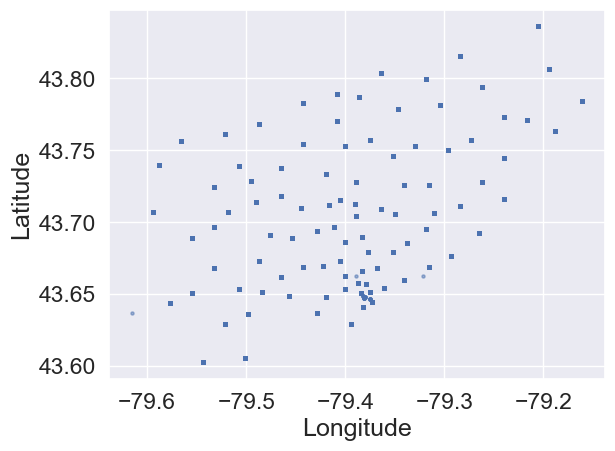

In [92]:
#first, let's convert the dates: we can use this later to maybe to plot cases over time 
cord_merged['Reported Date'] = pd.to_datetime(cord_merged['Reported Date'])

# quick sanity check: scatter plot for each case
plt.scatter(cord_merged['Longitude'], cord_merged['Latitude'], marker='o', s=5, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

This is fine but each case isn't a unique point here since multiple cases will have the same lat/long coordinates...

ideally, we would want to scatter the points within the boundaries of the neighborhood coordinates but for now, let's just add some jitter:

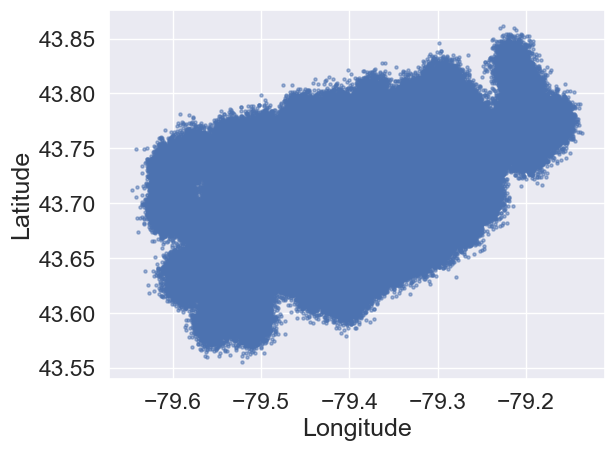

,Postal Code,Latitude,Longitude,Assigned_ID,Age Group,Neighbourhood Name,Reported Date,Client Gender,Latitude_jittered,Longitude_jittered
0,M1B,43.806686,-79.194353,23,60 to 69 Years,Malvern,2020-03-08,FEMALE,43.795603,-79.195595
1,M1B,43.806686,-79.194353,246,60 to 69 Years,Malvern,2020-03-20,FEMALE,43.808385,-79.192975
2,M1B,43.806686,-79.194353,302,50 to 59 Years,Malvern,2020-03-22,FEMALE,43.798182,-79.204690
3,M1B,43.806686,-79.194353,323,30 to 39 Years,Rouge,2020-03-23,MALE,43.785910,-79.198487
4,M1B,43.806686,-79.194353,339,30 to 39 Years,Rouge,2020-03-23,FEMALE,43.778782,-79.192810


In [93]:
# add jitter to lat and long coordinates to show actual case counts per neighborhood
jitter_amount = 0.01  # adjust as needed
cord_merged['Latitude_jittered'] = cord_merged['Latitude'] + np.random.normal(-jitter_amount, jitter_amount, size=len(cord_merged))
cord_merged['Longitude_jittered'] = cord_merged['Longitude'] + np.random.normal(-jitter_amount, jitter_amount, size=len(cord_merged))

# scatter plot:
plt.scatter(cord_merged['Longitude_jittered'], cord_merged['Latitude_jittered'], marker='o', s=5, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
cord_merged.head() #check the coordinates and new dataframe

<xarray.DataArray (Latitude_jittered: 600, Longitude_jittered: 800)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
Coordinates:
  * Longitude_jittered  (Longitude_jittered) float64 -79.65 -79.65 ... -79.14
  * Latitude_jittered   (Latitude_jittered) float64 43.56 43.56 ... 43.86 43.86
Attributes:
    x_range:  (-79.64655399844327, -79.13592709139688)
    y_range:  (43.555139939377426, 43.860990104363324)


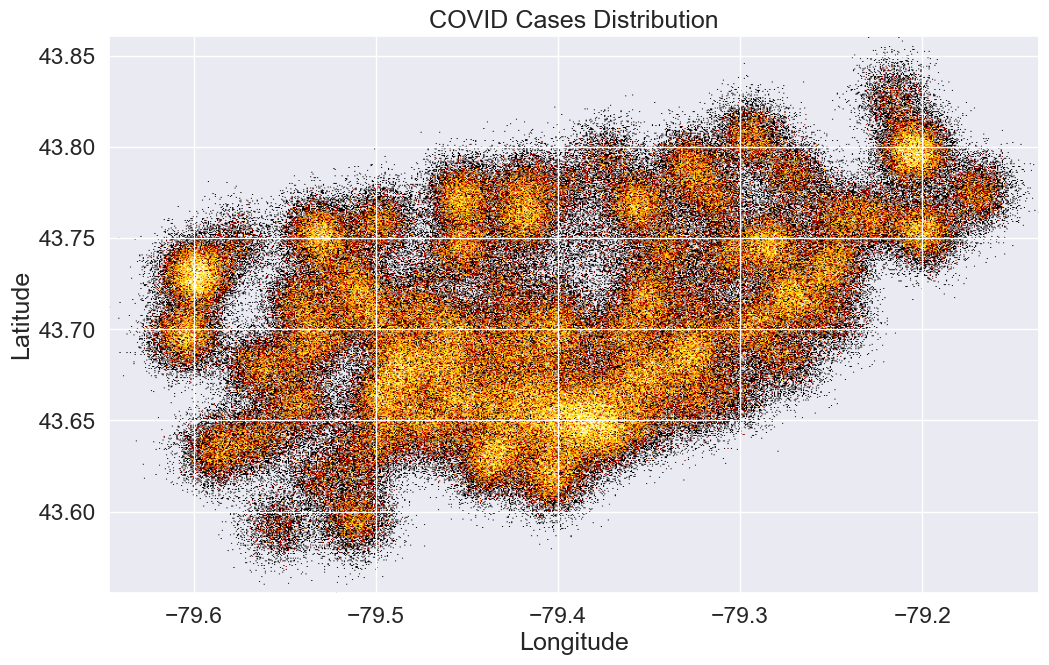

In [94]:
#Now, let's play around with datashader 

# create canvas
cvs = ds.Canvas(plot_width=800, plot_height=600)

# aggregate data
agg = cvs.points(cord_merged, 'Longitude_jittered', 'Latitude_jittered')
print(agg) #check the aggregation

# color mapping
img = tf.shade(agg, cmap=colorcet.fire, how='eq_hist')

# display basic graph by lat/long coordinates
plt.figure(figsize=(12, 8))
plt.imshow(img.to_pil(), extent=[cord_merged['Longitude_jittered'].min(), cord_merged['Longitude_jittered'].max(), cord_merged['Latitude_jittered'].min(), cord_merged['Latitude_jittered'].max()])
plt.title('COVID Cases Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

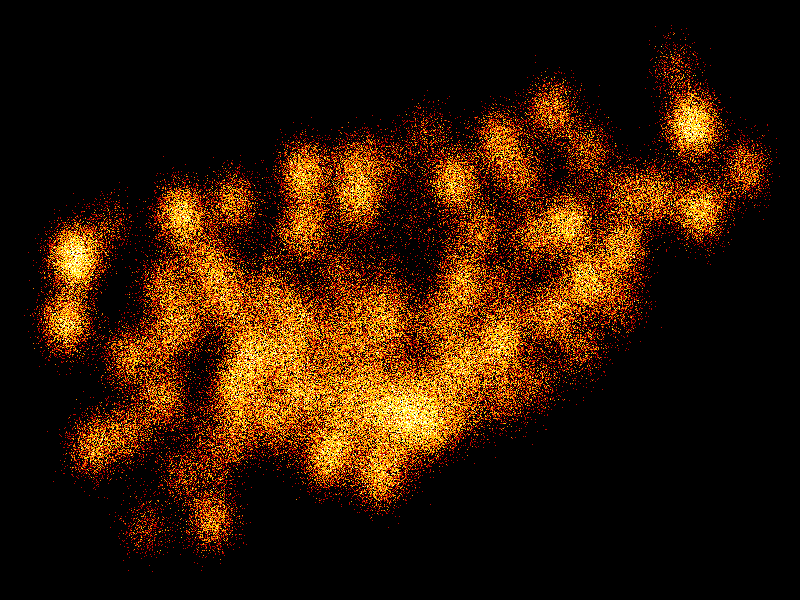

In [99]:
# let's make this look prettier
img = tf.shade(agg, cmap = colorcet.palette.fire, how='eq_hist')
ds.utils.export_image(img = img,filename = 'datashader_all',fmt = ".png",background = 'black')

Let's join this with the orignal geo coordinates so that we can plot a heatmap of the total num of cases per neighborhood. For this we will need the geospatial data for toronto. Downloaded from here: https://open.toronto.ca/dataset/neighbourhoods


In [103]:
path1 = r'C:\Users\Ksenia\OneDrive\Desktop\toronto-open-data-portal\toronto-nbrhoods-wgs84'
file_name2 = 'Neighbourhoods - 4326.shp'
file_path2 = os.path.join(path1, file_name2)

In [145]:
import geopandas as gpd

# Read the shapefile
nbrhood_geo_data = gpd.read_file(file_path2) #this reads in the file (need all the other file extensions in same folder as .shp file)

# Read the CSV file with data field labels
file_name3 = 'Neighbourhoods fields.csv' 
file_path3 = os.path.join(path1, file_name3)
nbrhood_geo_cols = pd.read_csv(file_path3, quotechar='"', encoding='utf-8')

print(nbrhood_geo_data.crs)  

EPSG:4326


In [146]:
nbrhood_geo_data.crs = 'EPSG:4326'

# Reproject to a different CRS
nbrhood_geo_data = nbrhood_geo_data.to_crs('EPSG:3161') 

In [147]:
nbrhood_geo_data.rename(columns=dict(zip(nbrhood_geo_cols.field, nbrhood_geo_cols.name)), inplace=True)
nbrhood_geo_data.head()


,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry
0,1,2502366,26022881,0,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"POLYGON ((1382638.832 11914785.471, 1382651.33..."
1,2,2502365,26022880,0,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"POLYGON ((1381671.908 11915728.695, 1381598.70..."
2,3,2502364,26022879,0,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"POLYGON ((1379102.021 11910320.788, 1379003.25..."
3,4,2502363,26022878,0,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"POLYGON ((1378671.329 11911127.419, 1378700.51..."
4,5,2502362,26022877,0,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"POLYGON ((1383259.926 11908934.598, 1383182.40..."


In [148]:
# remove the area code and trailing whitespace from the area names
nbrhood_geo_data['AREA_NAME'] = nbrhood_geo_data.AREA_NAME.str.replace(r'\s\(\d+\)', '') #changed this to raw string to avoid errors
set(nbrhood_geo_data.AREA_NAME).difference(set(covid_data['Neighbourhood Name']))

{'Avondale',
 'Bay-Cloverhill',
 'Bendale South',
 'Bendale-Glen Andrew',
 'Briar Hill-Belgravia',
 'Cabbagetown-South St.James Town',
 'Church-Wellesley',
 'Danforth East York',
 'Dovercourt Village',
 'Downsview',
 'Downtown Yonge East',
 "East L'Amoreaux",
 'East Willowdale',
 'Etobicoke City Centre',
 'Fenside-Parkwoods',
 'Fort York-Liberty Village',
 'Golfdale-Cedarbrae-Woburn',
 'Harbourfront-CityPlace',
 'Humber Bay Shores',
 'Islington',
 'Junction-Wallace Emerson',
 "L'Amoreaux West",
 'Malvern East',
 'Malvern West',
 'Mimico-Queensway',
 'Morningside Heights',
 'North St.James Town',
 'North Toronto',
 'Oakdale-Beverley Heights',
 "Parkwoods-O'Connor Hills",
 'South Eglinton-Davisville',
 'St Lawrence-East Bayfront-The Islands',
 'Wellington Place',
 'West Queen West',
 'West Rouge',
 'Weston-Pelham Park',
 'Woburn North',
 'Yonge-Bay Corridor',
 'Yonge-Doris'}

In [149]:
nbrhood_geo_data.rename(columns={'AREA_NAME':'Neighbourhood Name'}, inplace=True)
nbrhood_geo_data.head(158)


,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,Neighbourhood Name,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry
0,1,2502366,26022881,0,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"POLYGON ((1382638.832 11914785.471, 1382651.33..."
1,2,2502365,26022880,0,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"POLYGON ((1381671.908 11915728.695, 1381598.70..."
2,3,2502364,26022879,0,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"POLYGON ((1379102.021 11910320.788, 1379003.25..."
3,4,2502363,26022878,0,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"POLYGON ((1378671.329 11911127.419, 1378700.51..."
4,5,2502362,26022877,0,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"POLYGON ((1383259.926 11908934.598, 1383182.40..."
...,...,...,...,...,...,...,...,...,...,...,...,...
153,154,2502213,26022728,0,001,001,West Humber-Clairville,West Humber-Clairville (1),Not an NIA or Emerging Neighbourhood,NA,17827185.0,"POLYGON ((1365929.931 11917604.028, 1366021.95..."
154,155,2502212,26022727,0,024,024,Black Creek,Black Creek (24),Neighbourhood Improvement Area,NIA,17827201.0,"POLYGON ((1371338.533 11922451.368, 1371349.90..."
155,156,2502211,26022726,0,023,023,Pelmo Park-Humberlea,Pelmo Park-Humberlea (23),Not an NIA or Emerging Neighbourhood,NA,17827217.0,"POLYGON ((1370597.103 11918054.885, 1370919.67..."
156,157,2502210,26022725,0,022,022,Humbermede,Humbermede (22),Neighbourhood Improvement Area,NIA,17827233.0,"POLYGON ((1370855.086 11919099.916, 1370960.19..."


In [151]:
#ok need to merge based on area name with original covid dataset. 

ndf2 = pd.merge(covid_data, nbrhood_geo_data, on='Neighbourhood Name')
ndf2


,Assigned_ID,Age Group,Neighbourhood Name,Postal Code,Reported Date,Client Gender,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry
0,6,50 to 59 Years,Newtonbrook West,M2R,2/27/2020,MALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56..."
1,511,40 to 49 Years,Newtonbrook West,M2M,3/26/2020,FEMALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56..."
2,780,30 to 39 Years,Newtonbrook West,M2M,3/31/2020,MALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56..."
3,798,60 to 69 Years,Newtonbrook West,M2R,4/1/2020,MALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56..."
4,809,50 to 59 Years,Newtonbrook West,M2R,4/1/2020,FEMALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298233,423883,60 to 69 Years,Regent Park,M5A,1/1/2024,MALE,84,2502283,26022798,0,072,072,Regent Park (72),Neighbourhood Improvement Area,NIA,17826065.0,"POLYGON ((1384829.529 11910263.331, 1384749.13..."
298234,423938,90 and older,Regent Park,M5A,1/2/2024,FEMALE,84,2502283,26022798,0,072,072,Regent Park (72),Neighbourhood Improvement Area,NIA,17826065.0,"POLYGON ((1384829.529 11910263.331, 1384749.13..."
298235,424379,80 to 89 Years,Regent Park,M5A,1/5/2024,MALE,84,2502283,26022798,0,072,072,Regent Park (72),Neighbourhood Improvement Area,NIA,17826065.0,"POLYGON ((1384829.529 11910263.331, 1384749.13..."
298236,425012,80 to 89 Years,Regent Park,M5A,1/11/2024,MALE,84,2502283,26022798,0,072,072,Regent Park (72),Neighbourhood Improvement Area,NIA,17826065.0,"POLYGON ((1384829.529 11910263.331, 1384749.13..."


In [167]:
# group by 'Postal Code' and count the number of cases in each
cases = ndf2.groupby('Neighbourhood Name')['Assigned_ID'].count().reset_index()

# rename the columns for clarity
cases.columns = ['Neighbourhood Name', 'Number of Cases']
print(cases)

               Neighbourhood Name  Number of Cases
0                 Agincourt North             3111
1    Agincourt South-Malvern West             2761
2                       Alderwood             1454
3                           Annex             3855
4               Banbury-Don Mills             3387
..                            ...              ...
114                      Wychwood             2196
115                Yonge-Eglinton             1142
116                Yonge-St.Clair             1308
117       York University Heights             5685
118            Yorkdale-Glen Park             3055

[119 rows x 2 columns]


In [168]:
ndf3 = pd.merge(ndf2, cases, on='Neighbourhood Name')
ndf3

,Assigned_ID,Age Group,Neighbourhood Name,Postal Code,Reported Date,Client Gender,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry,Number of Cases
0,6,50 to 59 Years,Newtonbrook West,M2R,2/27/2020,MALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56...",4302
1,511,40 to 49 Years,Newtonbrook West,M2M,3/26/2020,FEMALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56...",4302
2,780,30 to 39 Years,Newtonbrook West,M2M,3/31/2020,MALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56...",4302
3,798,60 to 69 Years,Newtonbrook West,M2R,4/1/2020,MALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56...",4302
4,809,50 to 59 Years,Newtonbrook West,M2R,4/1/2020,FEMALE,117,2502250,26022765,0,036,036,Newtonbrook West (36),Not an NIA or Emerging Neighbourhood,NA,17826593.0,"POLYGON ((1377485.486 11922888.257, 1377459.56...",4302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298233,423883,60 to 69 Years,Regent Park,M5A,1/1/2024,MALE,84,2502283,26022798,0,072,072,Regent Park (72),Neighbourhood Improvement Area,NIA,17826065.0,"POLYGON ((1384829.529 11910263.331, 1384749.13...",1490
298234,423938,90 and older,Regent Park,M5A,1/2/2024,FEMALE,84,2502283,26022798,0,072,072,Regent Park (72),Neighbourhood Improvement Area,NIA,17826065.0,"POLYGON ((1384829.529 11910263.331, 1384749.13...",1490
298235,424379,80 to 89 Years,Regent Park,M5A,1/5/2024,MALE,84,2502283,26022798,0,072,072,Regent Park (72),Neighbourhood Improvement Area,NIA,17826065.0,"POLYGON ((1384829.529 11910263.331, 1384749.13...",1490
298236,425012,80 to 89 Years,Regent Park,M5A,1/11/2024,MALE,84,2502283,26022798,0,072,072,Regent Park (72),Neighbourhood Improvement Area,NIA,17826065.0,"POLYGON ((1384829.529 11910263.331, 1384749.13...",1490


In [174]:
#simplify the dataframe since there are a lot of columns we dont need:

ndf4 = ndf3[['Neighbourhood Name', 'OBJECTID', 'geometry', 'Number of Cases']]
ndf4

#remove duplicates and then plot? 
df_no_duplicates = ndf4.drop_duplicates()
df_no_duplicates

gdf = df_no_duplicates.set_geometry('geometry') #make sure to do this otherwise plot doesn't work

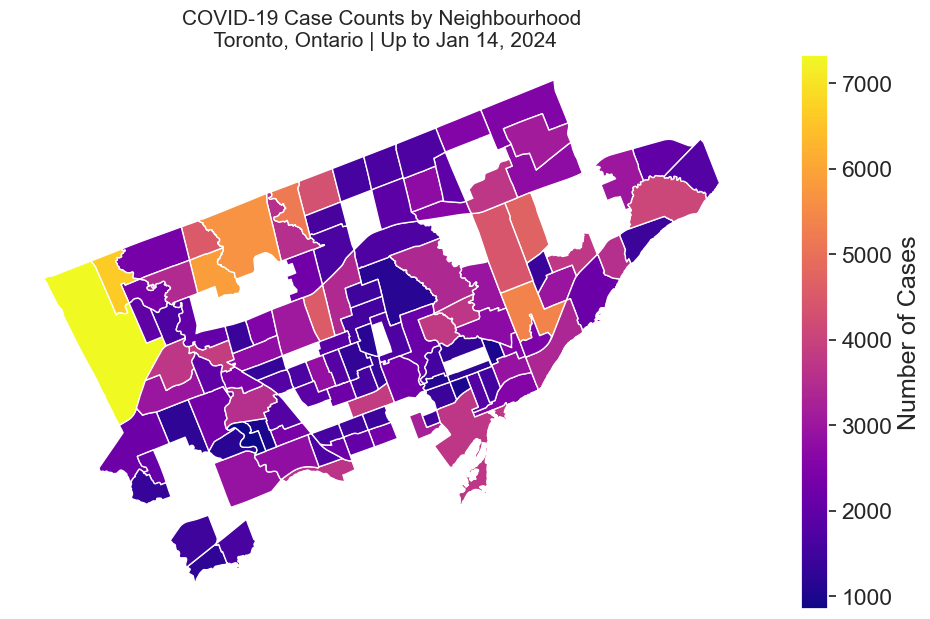

In [181]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# plot the choropleth map
gdf.plot(ax=ax,
                     column='Number of Cases',
                     cmap='plasma',
                     legend=True,
                     legend_kwds={'label':'Number of Cases',
                                  'orientation': 'vertical',
                                  'shrink': 0.9})

ax.set_title('COVID-19 Case Counts by Neighbourhood\n Toronto, Ontario | Up to Jan 14, 2024', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.axis('off')
plt.show()


missing some neighborhoods but we'll fix that later!